# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

The goal is to try to apply the techniques I have learnt by studying RL, and also come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define the task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent.
    - `agent.py`: Development of the RL agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.

For this project, I will define your own task in `task.py`.

I will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  


## Controlling the Quadcopter

There is a sample agent in the code cell below to show how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that I'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [31]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [32]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

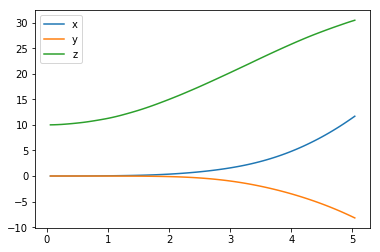

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

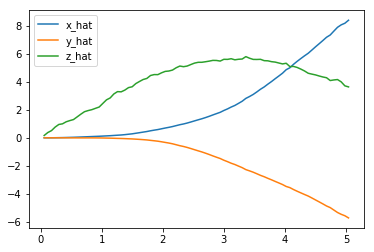

In [34]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, I can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

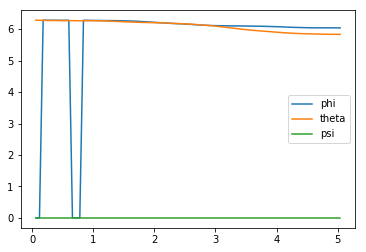

In [35]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

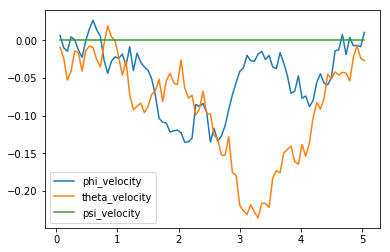

In [36]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, I can use the code cell below to print the agent's choice of actions.  

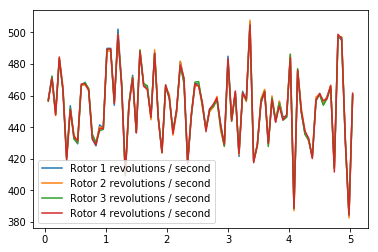

In [37]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, I will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [38]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ 11.68909275  -8.19253486  30.45953149   6.04081872   5.83366064   0.        ]
[ 8.41443636 -5.73495814  3.64280656]
[ 0.01062019 -0.02675096  0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for my purposes, it is easy to expand the size of the state vector by including the velocity information.  I can use any combination of the pose, velocity, and angular velocity.

## The Task

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [39]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

Episode = 1000, score = -50.028 (best = -46.902), noise_scale = 3.2625

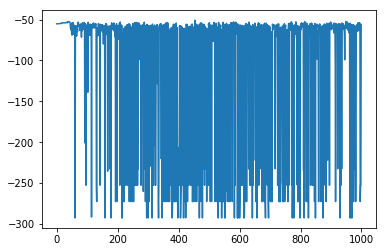

In [19]:
num_episodes = 1000
target_pos = np.array([0., 0., 100.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 
rewards = []

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            rewards.append(reward)
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()
plt.plot(rewards)

This agent should perform very poorly on this task.  And that's where the RL agent comes in!

## Define the Task, Design the Agent, and Train the RL Agent!

Amend `task.py` to specify a task of your choosing like takeoff, hover in place, land softly, or reach a target pose.  

After specifying the task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  I can borrow whatever you need from the sample agent, including ideas on how I might modularize the code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well. I will likely have to tweak various hyperparameters and the reward function for the task until I arrive at reasonably good behavior.

As I develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

Episode = 1000, score =  44.716, steps = 84 

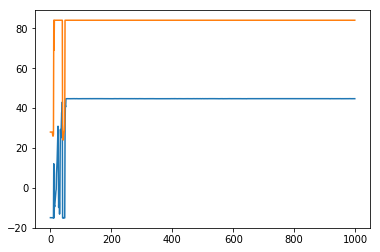

In [43]:
from agents.agent import DDPG
from agents.Noise import OUNoise

num_episodes = 1000
target_pos = np.array([0., 0., 100.])
task = Task(target_pos=target_pos)
agent = DDPG(task) 
rewards = []
steps = []
actions = []# Array with all same actions

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state)
        #action_mean = np.mean(action)
        actions.clear()
        for i in range(4):
            actions.append(action[0])
        next_state, reward, done = task.step(actions)
        agent.step(action,reward,next_state,done)
        state = next_state
        if done:
            rewards.append(reward)
            steps.append(agent.steps)
            #print("\nActions = {} ".format(actions), end="")
            print("\rEpisode = {:4d}, score = {:7.3f}, steps = {} ".format(i_episode, reward, agent.steps), end="")
            break       
    sys.stdout.flush()

plt.plot(rewards)
plt.plot(steps)

The graph avove contains episode vs. rewards (Blue) and episode vs. steps (Orange)

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

reward =  44.719 

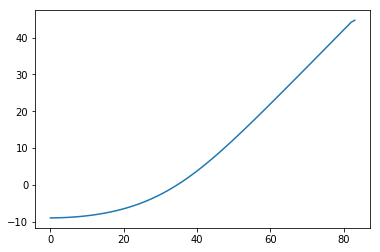

In [47]:

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
f_results = {x : [] for x in labels}
# Run the simulation, and save the results.
rewards2 = []
state = agent.reset_episode() # start a new episode
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        action = agent.act(state)
        actions.clear()
        for i in range(4):
            actions.append(action[0])
        next_state, reward, done = task.step(actions)
        agent.step(action,reward,next_state,done)
        state = next_state
        rewards2.append(reward)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            f_results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            print("reward = {:7.3f} ".format(reward), end="")
            break 
    
plt.plot(rewards2)
        

As shown in the steps vs. rewards for one episode graph above, the rewards are gradually increasing (almost linearly) with each step. 

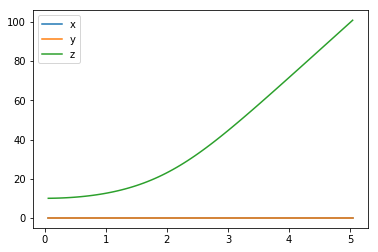

In [48]:
plt.plot(f_results['time'], f_results['x'], label='x')
plt.plot(f_results['time'], f_results['y'], label='y')
plt.plot(f_results['time'], f_results['z'], label='z')
plt.legend()
_ = plt.ylim()

The z position only changes with time, the x and y positions does not change at all due to same action values for all four propellers. The Z position varies from an initial place to the target position of 100 smoothly. 

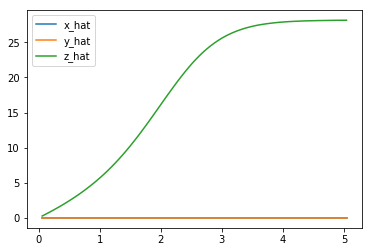

In [49]:
plt.plot(f_results['time'], f_results['x_velocity'], label='x_hat')
plt.plot(f_results['time'], f_results['y_velocity'], label='y_hat')
plt.plot(f_results['time'], f_results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

The x and y velocities are zero as the quadcopter was only moving vertically. The z velocity increases slowly and saturates as the quadcopter gets close to target z position. 

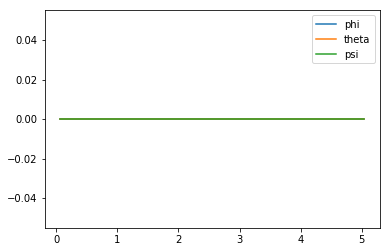

In [50]:
plt.plot(f_results['time'], f_results['phi'], label='phi')
plt.plot(f_results['time'], f_results['theta'], label='theta')
plt.plot(f_results['time'], f_results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

The quadcopter does not rotate or change its position with respect to the phi, theta, and psi.

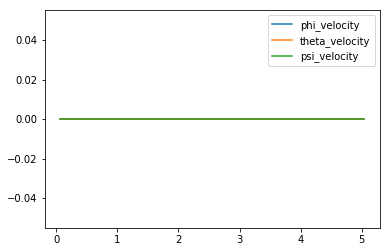

In [51]:
plt.plot(f_results['time'], f_results['phi_velocity'], label='phi_velocity')
plt.plot(f_results['time'], f_results['theta_velocity'], label='theta_velocity')
plt.plot(f_results['time'], f_results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

The quadcopter does not have any roll, pitch and yaw movements.  

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
- The task sets the action_repeat value to 3 which means that the state dimension is 6*3 = 18 since the quadcopter x,y, and z position along with x, y, and z linear velocities are considered. The action_repeat means that the six variables x,y, and z position and linear velocity are simulated three times and concatenated to form an 18 values long state. 

- The action size is set to one since the quadcopter is trained only to lift up vertically. 

- The position and the linear velocity was used to set the rewards function. If the difference between current position and target position was less than the magnitude of 20 between simulations, the rewards were positive. Similarly, if the linear velocity change was less than 16.67 between the simulations, the awards were positive. As the quad compter got close to the target position, the rewards increased with the maximum reward of 10 for being at the exact position. The linear velocity was restricted such that if the quadcopter was run too fast between simulations, the rewards were negative. The angular velocities were not considered for the reward as the action size was 1. There would not be any angular movement. 


**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
- Initially, I tried the basic policy iteration algorithm with discreate states. However, the algorithm did not work well and I spend a lot of time on it. It was a learning experiance though. Secondly, I tried the DDPG algorithm which worked best for me in the end. 

- My final choice of the hyperparameters are as following
    - For the exploration noise: mu = 0.1, theta =0.3, sigma = 0.3
    - For replay memory: batch size = 200
    - For the algorithm: gamma = 0.99, tau = 0.01
- The actor and critic methods used different neural nets.

**Actor**
```
Input layer of the size of state_size
Dense layer with 16 units and relu activation
Batch Normalization layer with default settings
Dense layer with 32 units and relu activation
Batch Normalization layer with default settings
Dense layer with 16 units and relu activation
Batch Normalization layer with default settings
Output dense layer of action_size and sigmoid activation
```

**Critic**
```
for states:
	Input layer of the size of state_size
	Dense layer with 16 units and relu activation
	Batch Normalization layer with default settings
	Dense layer with 32 units and relu activation
for actions:
	Input layer of the size of action_size
	Dense layer with 16 units and relu activation
	Batch Normalization layer with default settings
	Dense layer with 32 units and relu activation
states and actions combained
	Combination of states and actions layers
	Final dense layer with 1 unit for Q values
```

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
- Based on the episode rewards plot, the learning was easy since about 100 episodes the rewards saturated to a constant number. 
- Initially, the learning was stable, but after about 100 episode the learning was constant. So it was like the aha moment. 
- The mean reward over the last ten episodes was 44.71 which was almost the highest over all the episodes. Therefore, the final performance of the agent was good.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
- The hardest part of the project in successfully teaching the agent was the tuning of the hyperparameters. It took me a lot of time to tune the hyperparameters right especially the exploration parameters. My first try of finding best discrete time policy was also very time-consuming. Besides, the specification of the rewards function also took some thinking. I had to imagine the flying of the quadcopter in my mind based on the various graphs to figure out how I can build a better agent. The idea of single action and using velocity in the rewards and states occurred during physical simulation of the environment in my mind. With four different actions, the quadcopter was moving in all directions with a lot of angular velocities. So the hyperparameter and the rewards function were the challenging part of the project. 

- The quadcopter agent behaved badly with action size of 4. There was a lot of angular movement and also the agent was settling at a local minimum for some reason. As soon as I set the action size to 1 and tweaked the hyperparameters a little, the agent suddenly behaved like an intelligent person!